## Agent Supervisor 기초예제

아래에서는 **작업을 위임(delegate)하는 데 도움을 주는 에이전트 감독관(agent supervisor)과 함께 에이전트 그룹**을 만들 것입니다.



In [ ]:
%pip install langchain langchain_openai langsmith pandas langchain_experimental matplotlib langgraph langchain_core duckduckgo-search langchain-community

### Create tools

> 검색 엔진을 사용해 웹 리서치(web research)를 수행하는 에이전트와 그래프를 생성하는 에이전트

In [3]:
from typing import Annotated

from langchain_community.tools import DuckDuckGoSearchResults
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper

from langchain_experimental.tools import PythonREPLTool


wrapper = DuckDuckGoSearchAPIWrapper(region="de-de", time="d", max_results=5)
duck_tool = DuckDuckGoSearchResults(api_wrapper=wrapper, source="news")

# This executes code locally, which can be unsafe
python_repl_tool = PythonREPLTool()

## Helper Utilities

> 그래프에서 노드를 생성하는 데 사용할 헬퍼 함수를 정의하세요. 
>
> 이 함수는 **에이전트 응답을 사람의 메시지로 변환하는 작업을 처리**합니다. 
>
> **이는 그래프의 글로벌 상태에 추가하는 방법이기 때문에 중요**합니다.


In [4]:
from langchain_core.messages import HumanMessage

def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["messages"][-1].content, name=name)]}

## Create Agent Supervisor

> 이 함수는 **함수 호출(function calling)을 사용**하여 **다음 작업자 노드를 선택하거나 처리를 완료(finish)**합니다.

In [5]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from enum import Enum
from pydantic import BaseModel
from typing import Literal

members = ["Researcher", "Coder"]

# 다음 작업자들 간의 대화를 관리하는 관리자로서 당신은 다음 작업을 수행해야 합니다: {members}.
# 아래의 사용자 요청을 참고하여, 다음 작업을 수행할 작업자를 지정하세요.
# 각 작업자는 작업을 수행하고 그 결과와 상태를 보고할 것입니다.
# 모든 작업이 완료되면 "FINISH"로 응답하세요.

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = ["FINISH"] + members
class routeResponse(BaseModel):
    next: Literal["FINISH", "Researcher", "Coder"]


# 위 대화를 참고하여, 누가 다음으로 행동해야 하나요?
# 아니면 작업을 FINISH해야 하나요?
# 다음 중 하나를 선택하세요: {options}

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))


llm = ChatOpenAI(model="gpt-4o")

def supervisor_agent(state):
    supervisor_chain = (
        prompt
        | llm.with_structured_output(routeResponse)
    )
    return supervisor_chain.invoke(state)

## Construct Graph

> 이제 그래프를 구축할 준비가 되었습니다. 아래에, 방금 정의한 함수를 사용하여 상태 및 작업자 노드를 정의하세요.


In [6]:
import functools
import operator
from typing import Sequence, TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent

# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str


research_agent = create_react_agent(llm, tools=[tavily_tool])
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
code_agent = create_react_agent(llm, tools=[python_repl_tool])
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", code_node)
workflow.add_node("supervisor", supervisor_agent)

In [7]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
# Finally, add entrypoint
workflow.add_edge(START, "supervisor")

graph = workflow.compile()

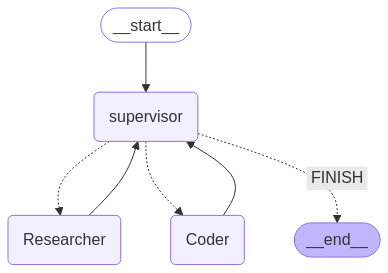

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [10]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Code hello world and print it to the terminal")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Coder'}}
----


Python REPL can execute arbitrary code. Use with caution.


{'Coder': {'messages': [HumanMessage(content='The code to print "Hello, World!" in Python is:\n\n```python\nprint(\'Hello, World!\')\n```\n\nWhen you run this code, the output will be:\n\n```\nHello, World!\n```', additional_kwargs={}, response_metadata={}, name='Coder')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


In [11]:
for s in graph.stream(
    {"messages": [HumanMessage(content="Write a brief research report on pikas.")]},
    {"recursion_limit": 10},
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Researcher'}}
----
{'Researcher': {'messages': [HumanMessage(content='### Research Report on Pikas\n\n#### Introduction\nPikas are small, herbivorous mammals belonging to the family Ochotonidae, distinctively known for their round bodies, small size, and no visible tails. They are more closely related to rabbits and hares, sharing the order Lagomorpha. Often referred to as "whistling hares" due to their high-pitched alarm calls, pikas can be found in mountainous regions across North America and Asia.\n\n#### Physical Characteristics\nPikas are small, with a body length of 15 to 23 centimeters (6 to 9 inches) and weighing between 120 to 350 grams. Their fur is dense and soft, typically grey or brown, allowing them to blend into rocky environments. \n\n#### Habitat and Distribution\nPikas primarily inhabit cold climates, thriving in rocky mountain slopes and open steppe environments. In North America, they are commonly found in the Rocky Mountains, the Sierra Nev

In [12]:
for s in graph.stream(
    {"messages": [HumanMessage(content="사막여우에 대한 간략한 리포트를 한글로 작성해줘.")]},
    {"recursion_limit": 10},
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Researcher'}}
----
{'Researcher': {'messages': [HumanMessage(content='사막여우(Fennec Fox)는 북아프리카의 사하라 사막에 서식하는 작은 야행성 여우로, 학명은 Vulpes zerda입니다. 이들은 특히 큰 귀로 유명하며, 이는 체열 조절과 사막 내에서의 소리 감지에 도움을 줍니다. 사막여우의 몸길이는 약 24-41 cm, 귀 길이는 10-15 cm이며, 꼬리 길이는 약 18-31 cm에 달합니다.\n\n사막여우는 주로 야행성으로, 낮 동안의 뜨거운 사막 기온을 피하여 밤에 활동합니다. 이들은 주로 작은 포유동물, 곤충, 과일 등을 먹으며, 물이 부족한 환경에서도 생존할 수 있도록 신장이 발달해 물을 효율적으로 보존합니다.\n\n사회적 동물로 무리를 지어 생활하며, 굴을 파고 그 안에서 번식 및 보호를 받습니다. 천적은 주로 올빼미와 같은 조류들이며, 인간 활동으로 인해 서식지가 위협받기도 합니다.\n\n사막여우는 그 귀여운 외모로 인해 반려동물로 인기가 있지만, 이는 자연 서식지를 위협할 수 있으므로 신중한 접근이 필요합니다. 자연 상태에서 이들은 평균적으로 10년 정도 살며, 포식자로부터 보호받기 위해 사회적 구조와 여러 가지 방어 기제를 발전시켰습니다.', additional_kwargs={}, response_metadata={}, name='Researcher')]}}
----
{'supervisor': {'next': 'FINISH'}}
----
